# **Problem Statement**
---
In this assessment, you will be tasked with building a
machine learning model capable of
detecting the emotions expressed by a person in an image using Python. Emotion detection
from images is an exciting and challenging problem in the field of computer vision and artificial
intelligence. Your goal is to leverage the power of machine learning algorithms to accurately
predict the emotional state of individuals.

## **Import & EDA of Dataset**



---

In [ ]:
import pandas as pd
import math
import numpy as np
import time
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
import tensorflow as tf
from tensorflow.keras.models import Model
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix ,classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense ,GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Sequential


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SAMESPACE_Assignment/fer2013/fer2013.csv')
df.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


**Dataset consists of 35887 instances which represents grayscale images of faces with the emotions associated with those images**

---





In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


**This implies at any given instance in the dataset , the size of image is 48 x 48**

---

In [ ]:
math.sqrt(len(df.pixels[np.random.randint(1,df.shape[0])].split(' ')))

48.0

**This implies the  dataset consists of 7 emotions (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)**

---

In [ ]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [ ]:
df['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1])

**Maximum data points are for happy emotion and its the feature we need to lookout for so the model is not biased**

---

In [ ]:
df['emotion'].value_counts().max()

8989

**Minimum data point are for Disgust emotion**

---

In [ ]:
df['emotion'].value_counts().min()

547

**Checking for null values in the target variable to improve learning of our model and avoid wrong estimation of values**

---

In [ ]:
df['emotion'].isnull().sum()

0

In [ ]:
df['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

##**Visualizing the Data**
---

In [ ]:
#number of classes
n_classes = len(df['emotion'].unique())

In [ ]:
#Used while predictions
Emotions = {0:'Angry',1:'Disgust', 2:'Fear', 3:'happy', 4: 'sad', 5: 'Surprise', 6: 'Neutral'}

In [ ]:
#Seperating pixels of each instance by white space and converting them into arrays of shape 48,48,1
Images = df['pixels'].apply(lambda x: np.array(x.split(' ')).reshape(48, 48,1).astype('float32'))

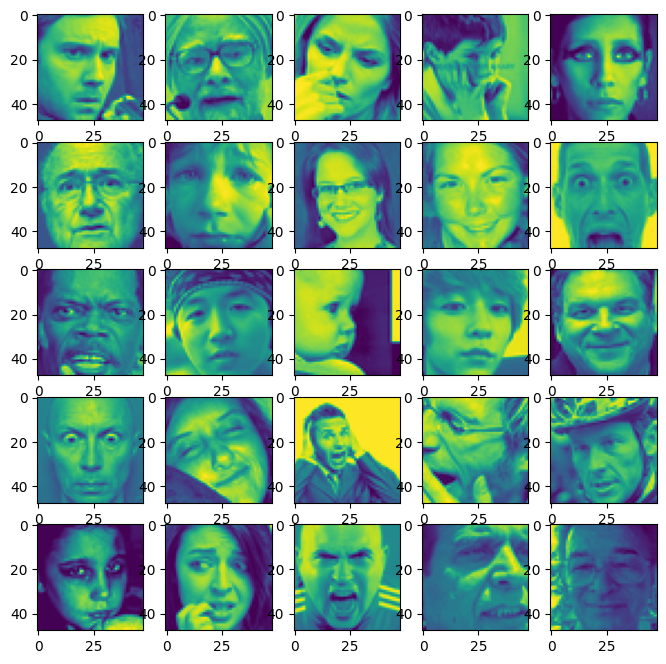

In [ ]:
#Plotting sample images
fig, axes = plt.subplots(5,5, figsize=(8,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(Images[i])
    ax.set_xticks
    ax.set_yticks
    plt.show

##**Data Preparation for Training and Validation sets (USED IN TRIAL 1)**
---

In [ ]:
#Images are stacked one after other to make a 3D array
Images_arr = np.stack(Images, axis =0)

In [ ]:
# Values of Target Variable
labels = df.emotion.values

In [ ]:
#Splitting into train and test data
X_train1, X_test1, y_train1, y_test1 = train_test_split(Images_arr,labels,  test_size = 0.25,shuffle=True,stratify = labels, random_state = 42)

In [ ]:
X_train1.shape,y_train1.shape,y_test1.shape

((26915, 48, 48, 1), (26915,), (8972,))

In [ ]:
#Converting the class vectors to binary class matrix to use with categorical cross entropy
y_train1= to_categorical(y_train1, num_classes=n_classes)
y_test1 = to_categorical(y_test1, num_classes=n_classes)

In [ ]:
y_train1.shape

(28709,)

##**Data Preparation to Ensure proper distribution of Dataset(USED IN TRIAL 2)**
---

In [ ]:
#splitting in groups in reference with originak distribution
Usage = [g for _, g in df.groupby('Usage')]
Training = Usage[2]
Validation = Usage[1]
Testing = Usage[0]

In [ ]:
#Removing the extra dimension of usage
Training = Training.drop(labels=['Usage'], axis=1)
Validation= Validation.drop(labels=['Usage'], axis=1)
Testing = Testing.drop(labels=['Usage'], axis=1)

In [ ]:
y_train_n = Training["emotion"]
y_val_n = Validation["emotion"]
y_test_n = Testing["emotion"]

In [ ]:
X_train_n = Training["pixels"]
X_val_n = Validation["pixels"]
X_test_n = Testing["pixels"]

In [ ]:
#preprocessing inputs to with suitable size and data type for model
def preprocess(X):
    X = np.array([np.fromstring(image, np.uint8, sep=' ') for image in X])
    X= X/255
    X = X.reshape(-1, 48, 48)
    return X

In [ ]:
X_train_n = preprocess(X_train_n)
X_val_n= preprocess(X_val_n)
X_test_n = preprocess(X_test_n)

In [ ]:
#Encoding the target variables
y_train_n = to_categorical(y_train_n, num_classes=7)
y_val_n  = to_categorical(y_val_n , num_classes=7)
y_test_n = to_categorical(y_test_n, num_classes=7)

###**Handling Class Imbalance**

---

####**Balancing by weights assigned during training**
---

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(y_train1),
                                        y = y_train1 )
#Passing as a dictionary format to avoid errors
weights = {}
for i in range(len(class_weights)):
    weights[i] = class_weights[i]
print(weights)

{0: 1.034993270524899, 1: 9.378048780487806, 2: 1.0010413954699298, 3: 0.5703055473153367, 4: 0.8435717419921018, 5: 1.2812395868043986, 6: 0.8272375215146299}


####**SMOTE (Not Implemeneted due to poor performance)**
---

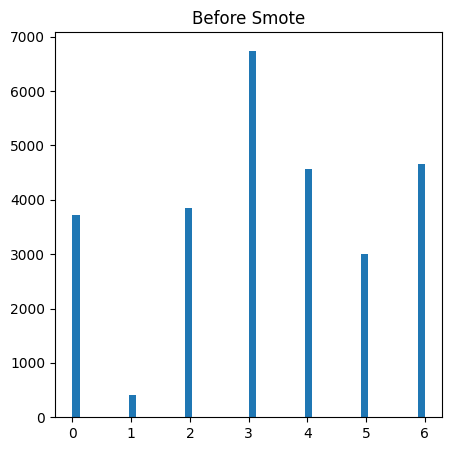

In [ ]:
plt.figure(figsize = (5,5))
plt.hist(y_train1, bins=50)
plt.title('Before Smote')
plt.show()

In [ ]:
Resize = X_train1.reshape(len(X_train1), 48 * 48 * 1)
smt = SMOTE(sampling_strategy='minority',k_neighbors=7)
X_train, y_train = smt.fit_resample(Resize, y_train1)

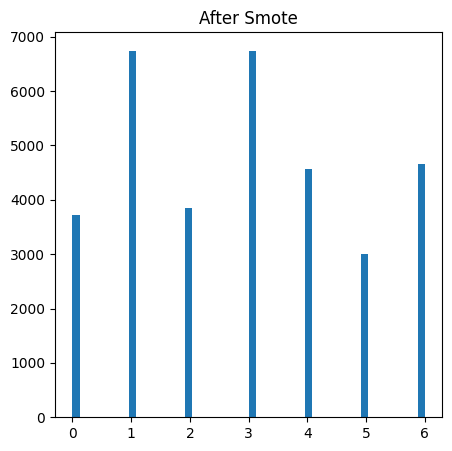

In [ ]:
plt.figure(figsize = (5,5))
plt.hist(y_train, bins=50)
plt.title('After Smote')
plt.show()

##**Data Augmentation on the images**

---
Augmentation helps to increase the variation in data so that we can train the model for more realistic images it will encounter in real time and we can build a well generalized model

In [ ]:
#Scaling the image pixels
Train_DataGEN = ImageDataGenerator(horizontal_flip=True,
                           shear_range=0.2, #distorted along an axis to create the perception angles
                           zoom_range=0.2 )
Test_DataGEN = ImageDataGenerator(rescale=1./255)

In [ ]:
Training = Train_DataGEN.flow(X_train1, y_train1, batch_size= 32)
Test = Test_DataGEN.flow(X_test1, y_test1,batch_size= 32)

##**Model Creation & Training**

##**TRIAL 1 : Baseline Model**     


*   Model : 3 convolutional layers with encoder path & 2 dense layer
*   Parameters : ADAM(0.001 LR) , Batch size = 64 , Epochs = 100
* Handled class imbalance by weight




In [ ]:
model = tf.keras.models.Sequential([

  # Add convolutions and max pooling


  tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='valid',kernel_initializer='he_normal',input_shape=(48, 48, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.BatchNormalization(axis=1),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu',kernel_initializer='he_normal',padding='same'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.BatchNormalization(axis=1),
  tf.keras.layers.Conv2D(256, (3,3), activation='relu',kernel_initializer='he_normal',padding='same'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(rate = 0.5),

  tf.keras.layers.Flatten(),

  #Final Layers of Dense Neural network
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32,activation='relu'),
  tf.keras.layers.Dense(n_classes, activation='softmax') #7 categories of output layers
])



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 64)       92        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 128)      0         
 2D)                                                             
                                                        

In [ ]:
# Compiling the model with the adam optimizer
opt = keras.optimizers.Adam(learning_rate=1e-03)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
call_back = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=12,verbose =1)

In [ ]:
history1 = model.fit(X_train1,y_train1,
                   validation_split = 0.25,
                     batch_size = 64,
                   class_weight=weights,
                    callbacks = [call_back],
                    epochs = 100)

####**Model Performance Report**

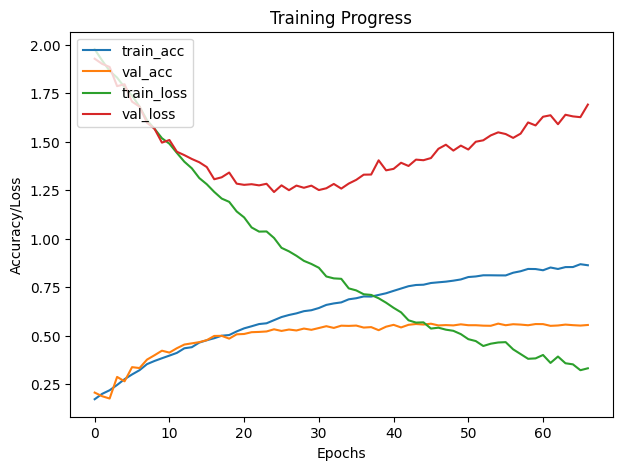

In [ ]:
def plot_hist(hist):
    plt.figure(figsize = (7,5))
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(history1)

**Predictions**

---

actual : happy
1/1 [==============================] - 0s 41ms/step
predicted : Angry


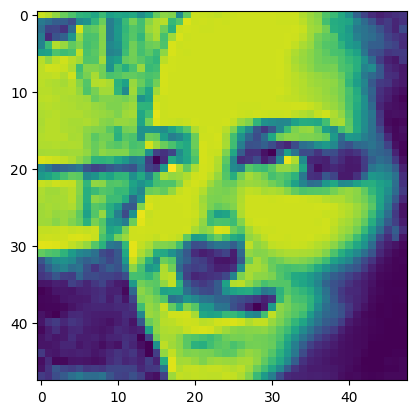

actual : Fear
1/1 [==============================] - 0s 71ms/step
predicted : Surprise


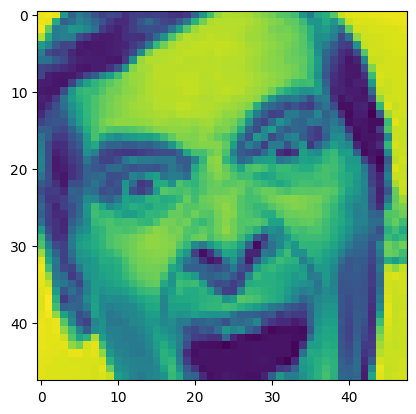

actual : happy
1/1 [==============================] - 0s 27ms/step
predicted : happy


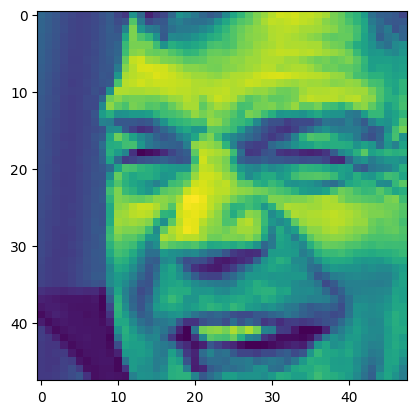

actual : happy
1/1 [==============================] - 0s 38ms/step
predicted : Fear


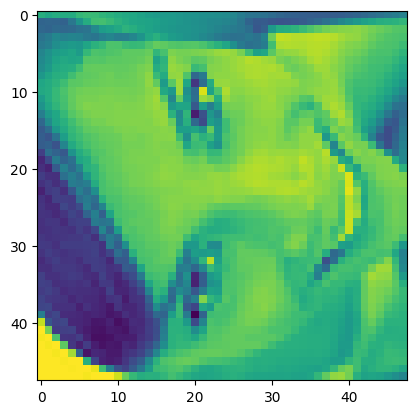

actual : happy
1/1 [==============================] - 0s 27ms/step
predicted : happy


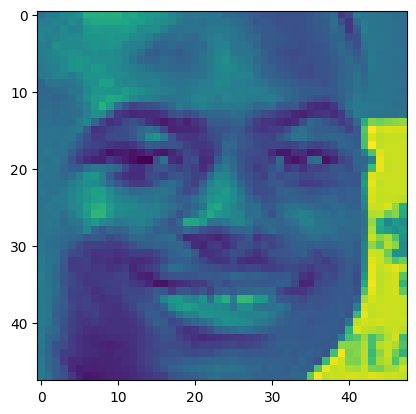

actual : Fear
1/1 [==============================] - 0s 27ms/step
predicted : happy


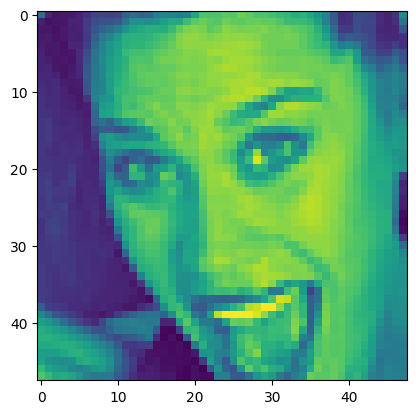

actual : Surprise
1/1 [==============================] - 0s 27ms/step
predicted : happy


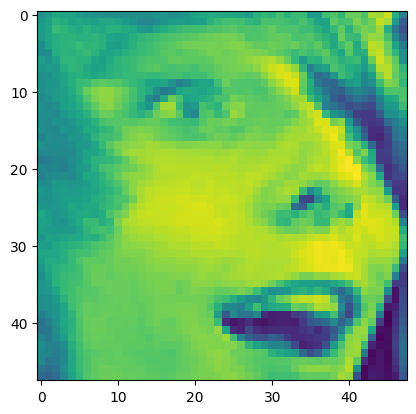

actual : Surprise
1/1 [==============================] - 0s 27ms/step
predicted : Surprise


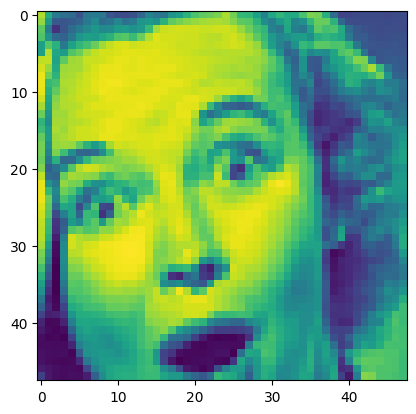

actual : Surprise
1/1 [==============================] - 0s 26ms/step
predicted : Surprise


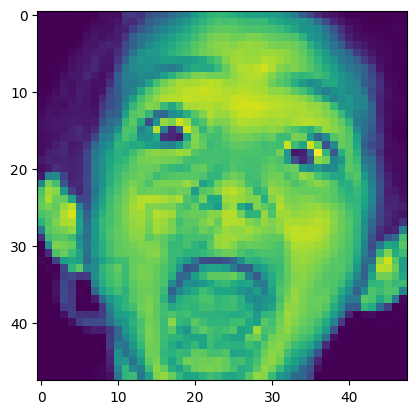

actual : happy
1/1 [==============================] - 0s 26ms/step
predicted : happy


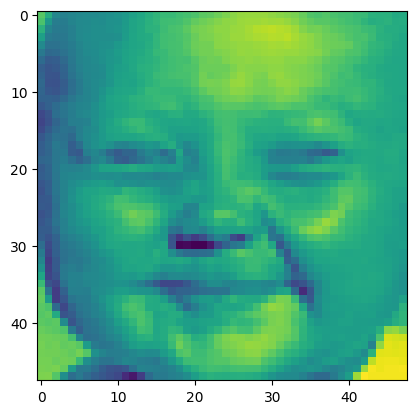

In [ ]:
for i in np.arange(0,10):
  print("actual :", Emotions[y_test1[i]])
  prediction = model.predict(tf.expand_dims(X_test1[i],0)).argmax()
  plt.imshow(X_test1[i])
  print("predicted :", Emotions[prediction])
  plt.show()
  #time.sleep(5)

In [ ]:
y_pred1 = np.argmax(model.predict(X_test1), axis=1)

225/225 [==============================] - 1s 3ms/step


In [ ]:
#To avoid dimension error
y_testing = to_categorical(y_test1, num_classes=n_classes)

**F1 Score**

---

In [ ]:
print(classification_report(np.argmax(y_testing , axis=1), y_pred1))

              precision    recall  f1-score   support

           0       0.47      0.46      0.46       991
           1       0.79      0.42      0.55       109
           2       0.45      0.38      0.41      1024
           3       0.71      0.81      0.76      1798
           4       0.43      0.45      0.44      1216
           5       0.74      0.72      0.73       800
           6       0.53      0.51      0.52      1240

    accuracy                           0.57      7178
   macro avg       0.59      0.54      0.55      7178
weighted avg       0.57      0.57      0.57      7178



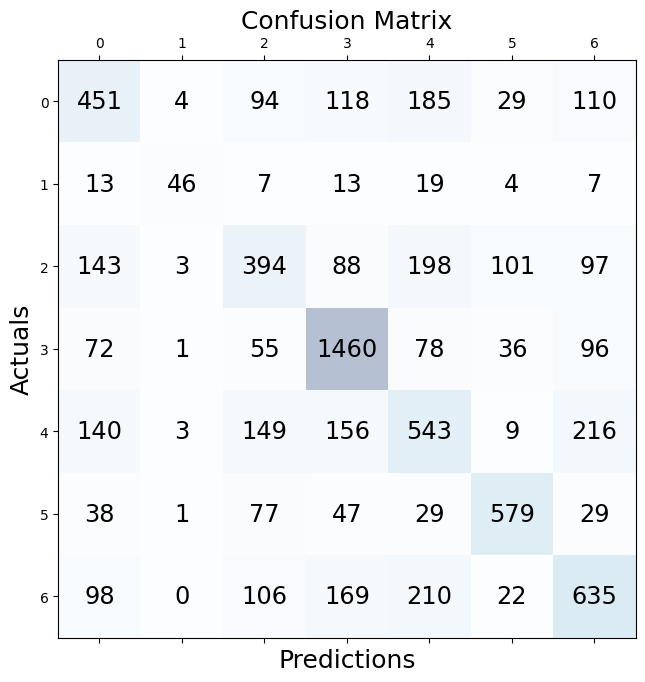

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_testing ,axis=1), y_pred1)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## TRIAL 2
* Model with Increased Complexity
* Including Data Augmentation

In [ ]:
model2 = tf.keras.models.Sequential([

  tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='same',kernel_initializer='he_normal',input_shape=(48, 48, 1)),
  tf.keras.layers.BatchNormalization(axis=1),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='same'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(rate = 0.5),


  tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
  tf.keras.layers.BatchNormalization(axis=1),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(rate = 0.5),

  tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding='same'),
  tf.keras.layers.BatchNormalization(axis=1),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding='same'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(rate = 0.5),

   tf.keras.layers.Conv2D(256, (3,3), activation='relu',kernel_initializer='he_normal',padding='same'),
   tf.keras.layers.BatchNormalization(axis=1),
   tf.keras.layers.MaxPooling2D(2, 2),
   tf.keras.layers.Dropout(rate = 0.3),


  tf.keras.layers.Flatten(),

  #Final Layers of Dense Neural network
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(n_classes, activation='softmax') #7 categories of output layers
])

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_12 (Bat  (None, 48, 48, 32)       192       
 chNormalization)                                                
                                                                 
 conv2d_22 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 24, 24, 64)        1

In [ ]:
# Compiling the model with the adam optimizer
opt = keras.optimizers.Adam(learning_rate=1e-03)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size = 128
#Implementing callback to monitor improvement in learning via val_accuracy
call_back = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=12,verbose =1)

In [ ]:
Train_DataGEN.fit(X_train_n)

In [ ]:
Training_2 = Train_DataGEN.flow(X_train_n,y_train_n)
Test_2 = Test_DataGEN.flow(X_val_n,y_val_n)

In [ ]:
history_2 = model2.fit(Training_2,
                    validation_data = Test_2 ,
                  #  steps_per_epoch = len(X_train)/batch_size,
                    batch_size = batch_size,
                    callbacks = [call_back],
                    epochs = 50)

###**Model Performace Reports**

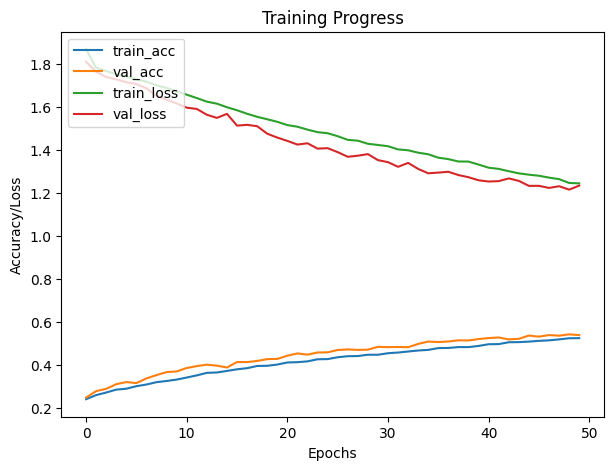

In [ ]:
def plot_hist(hist):
    plt.figure(figsize = (7,5))
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(history_2)

**Predictions**

---

In [ ]:
score, acc = model2.evaluate(X_test_n, y_test_n)

113/113 [==============================] - 1s 5ms/step - loss: 1.3659 - accuracy: 0.6236


In [ ]:
y_pred = np.argmax(model2.predict(X_test_n), axis=1)

113/113 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 38ms/step
predicted : Fear


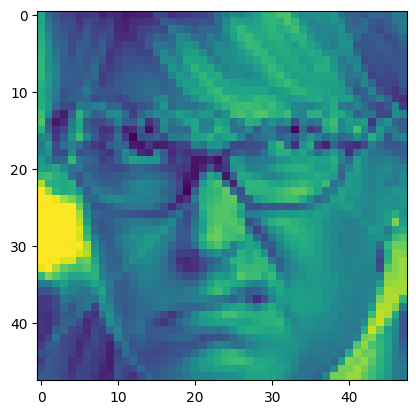

1/1 [==============================] - 0s 34ms/step
predicted : Angry


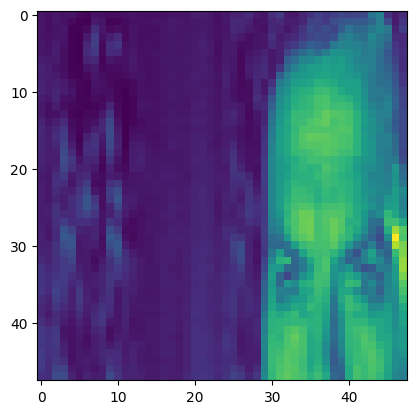

1/1 [==============================] - 0s 35ms/step
predicted : Fear


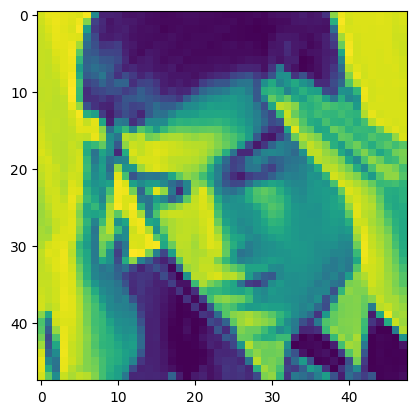

1/1 [==============================] - 0s 22ms/step
predicted : sad


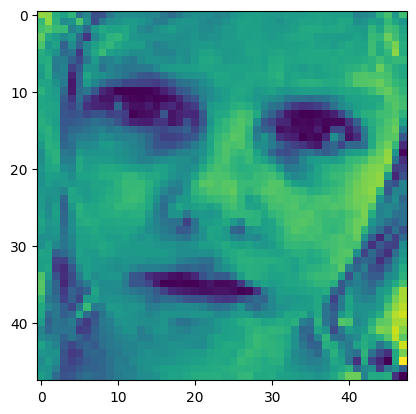

1/1 [==============================] - 0s 22ms/step
predicted : sad


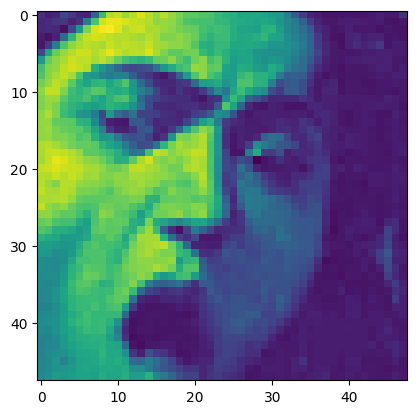

1/1 [==============================] - 0s 23ms/step
predicted : Angry


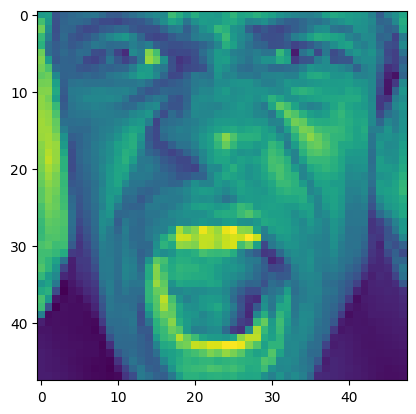

1/1 [==============================] - 0s 23ms/step
predicted : Fear


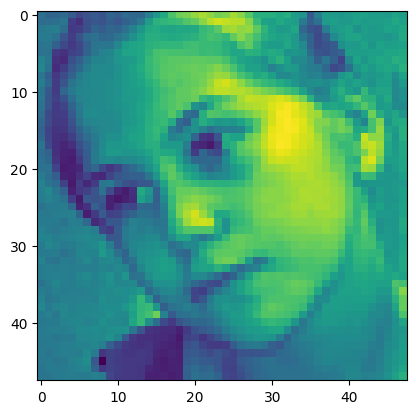

1/1 [==============================] - 0s 23ms/step
predicted : happy


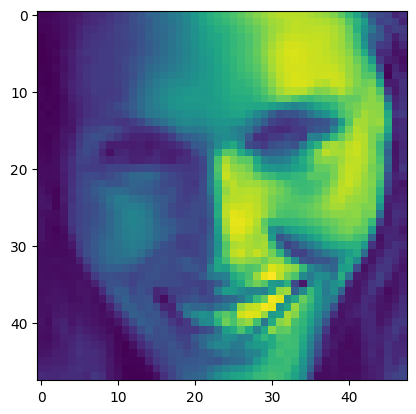

1/1 [==============================] - 0s 24ms/step
predicted : Fear


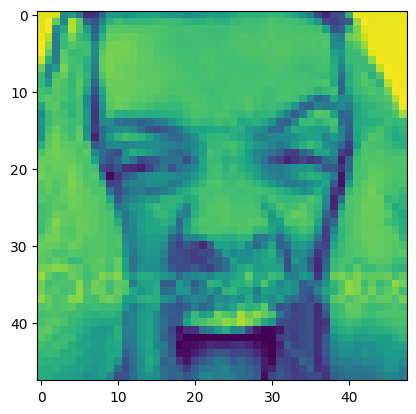

1/1 [==============================] - 0s 34ms/step
predicted : happy


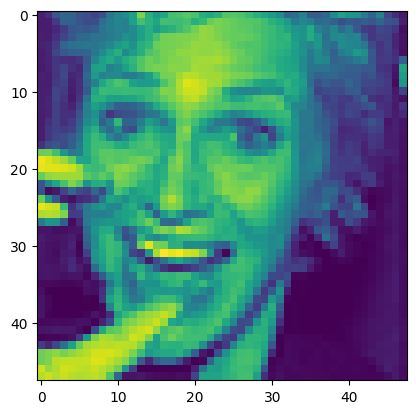

1/1 [==============================] - 0s 33ms/step
predicted : Surprise


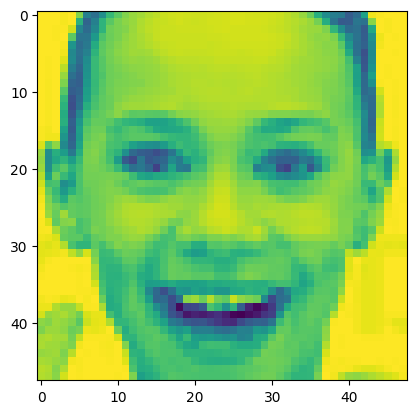

1/1 [==============================] - 0s 34ms/step
predicted : happy


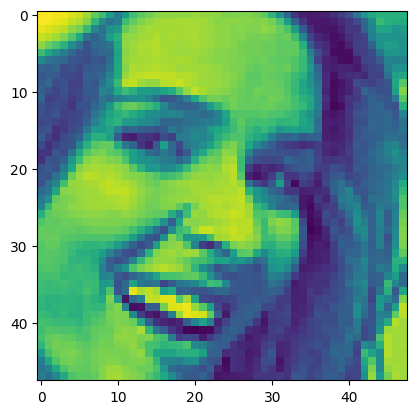

1/1 [==============================] - 0s 54ms/step
predicted : Neutral


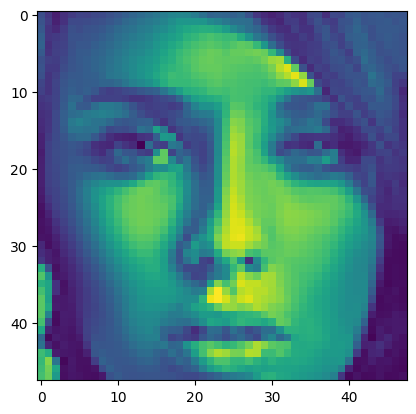

1/1 [==============================] - 0s 33ms/step
predicted : sad


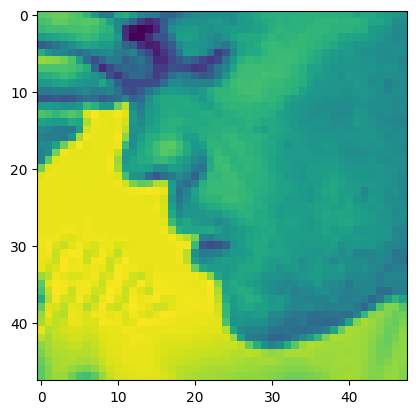

1/1 [==============================] - 0s 32ms/step
predicted : Neutral


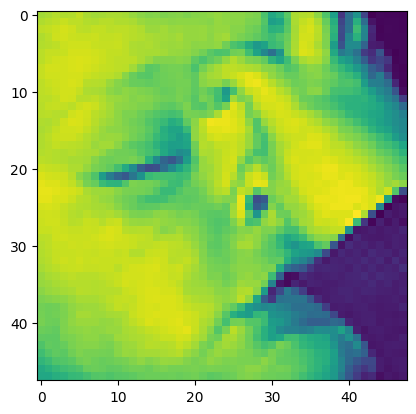

In [ ]:
for i in np.arange(0,15):
  prediction = model2.predict(tf.expand_dims(X_test_n[i],0)).argmax()
  plt.imshow(X_test_n[i])
  print("predicted :", Emotions[prediction])
  plt.show()

**F1 Score**

---

In [ ]:
#Accuracy Metrics
print(classification_report(np.argmax(y_test_n, axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.54      0.44      0.49       491
           1       0.62      0.67      0.64        55
           2       0.55      0.38      0.45       528
           3       0.78      0.85      0.82       879
           4       0.46      0.57      0.51       594
           5       0.79      0.76      0.78       416
           6       0.57      0.60      0.58       626

    accuracy                           0.62      3589
   macro avg       0.62      0.61      0.61      3589
weighted avg       0.62      0.62      0.62      3589



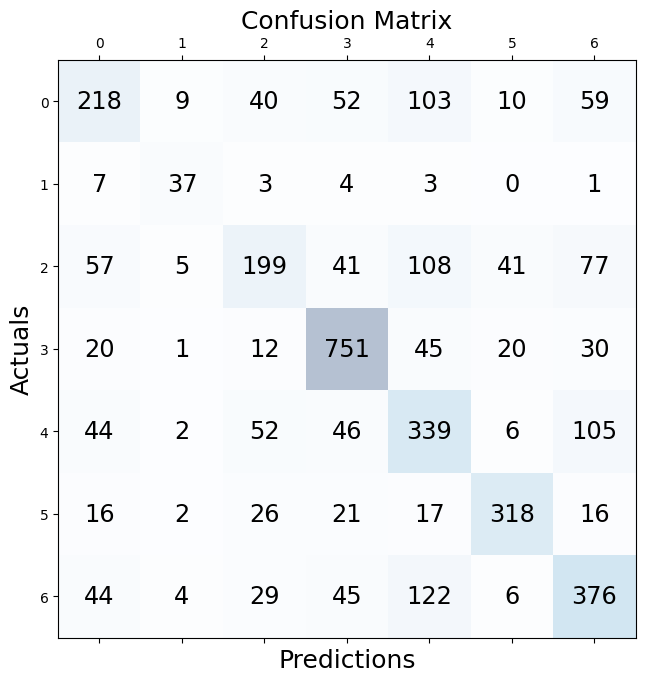

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_test,axis=1), y_pred)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## Transfer Learning


---
https://keras.io/api/applications/vgg/


###**Data Processing for Transfer Learning as the model takes RGB Input Images**

---

In [ ]:
Images1 = df['pixels'].apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))

In [ ]:
Images1 =np.stack(Images1,axis=0)

#converting to RGB with CV2 function
IMG_RGB =[]
for i in range(len(Images1)):
        IMG_RGB.append(cv2.cvtColor(Images1[i], cv2.COLOR_GRAY2RGB))

IMG_RGB = np.array(IMG_RGB)
IMG_RGB.shape

(35887, 48, 48, 3)

In [ ]:
#target variable
Labels = df.emotion.values

In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'emotion'.
Labels =label_encoder.fit_transform(df['emotion'])
Labels = to_categorical(Labels)
Labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
#splitting the dataset
X_train2, X_test2, y_train2, y_test2 = train_test_split(IMG_RGB,Labels, stratify = Labels, test_size = 0.15,shuffle= True,random_state = 42)

In [ ]:
#normalizing the values
X_train2 = X_train2/255.
X_test2 = X_test2/255.

###**Data Augmentation**

In [ ]:
train_data= ImageDataGenerator(
                               rotation_range = 15,
                               width_shift_range = 0.15,
                               height_shift_range = 0.15,
                                shear_range = 0.15,
                                 zoom_range = 0.15,
                                   horizontal_flip = True,
                               fill_mode='nearest')
test_data = ImageDataGenerator( rescale=1./255)

In [ ]:
train_data.fit(X_train2)

In [ ]:
Training1 = train_data.flow(X_train2, y_train2)

###**Model**

*   VGG19
*   SGD Optimizer



In [ ]:
VGG19 = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(48,48,3)
)

In [ ]:
#Did not train the layers till 2 block, started training 3rd block onwards
for layer in VGG19.layers[:7]:
  layer.trainable = False

In [ ]:
  for i, layer in enumerate(VGG19.layers):
        tf.print(i, layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_conv4 True
11 block3_pool True
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True


In [ ]:
output = VGG19.layers[-2].output
output = Flatten()(output)
output = Dense(512, activation='relu')(output)
output = Dropout(0.5)(output)
output = Dense(n_classes, activation='softmax')(output)

In [ ]:
model_tf = Model(inputs=VGG19.input, outputs=output)
model_tf.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

In [ ]:
model_tf.compile(loss = 'categorical_crossentropy',
              optimizer = keras.optimizers.SGD(learning_rate=1e-03,nesterov=True),
              metrics = ['accuracy'])

In [ ]:
call_back = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=12,verbose =1)

In [ ]:
batch_size = 32

In [ ]:
histor_tf= model_tf.fit(Training1 ,validation_data =( X_test2, y_test2) ,
                   steps_per_epoch = len(X_train2) // batch_size,
                    callbacks = [call_back],
                   epochs = 50)

Epoch 1/50
953/953 [==============================] - 55s 54ms/step - loss: 1.6935 - accuracy: 0.3252 - val_loss: 1.5792 - val_accuracy: 0.3876
Epoch 2/50
953/953 [==============================] - 53s 56ms/step - loss: 1.5105 - accuracy: 0.4210 - val_loss: 1.3697 - val_accuracy: 0.4842
Epoch 3/50
953/953 [==============================] - 50s 53ms/step - loss: 1.4273 - accuracy: 0.4540 - val_loss: 1.3072 - val_accuracy: 0.5074
Epoch 4/50
953/953 [==============================] - 54s 56ms/step - loss: 1.3660 - accuracy: 0.4807 - val_loss: 1.2571 - val_accuracy: 0.5195
Epoch 5/50
953/953 [==============================] - 54s 56ms/step - loss: 1.3229 - accuracy: 0.4979 - val_loss: 1.2775 - val_accuracy: 0.5158
Epoch 6/50
953/953 [==============================] - 51s 54ms/step - loss: 1.2903 - accuracy: 0.5080 - val_loss: 1.2135 - val_accuracy: 0.5410
Epoch 7/50
953/953 [==============================] - 55s 57ms/step - loss: 1.2755 - accuracy: 0.5127 - val_loss: 1.2053 - val_accuracy:

####**Model Perfromance Reports**

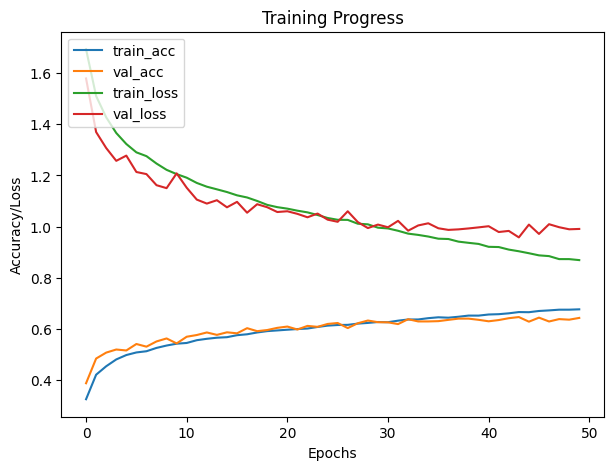

In [ ]:
def plot_hist(hist):
    plt.figure(figsize = (7,5))
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()
plot_hist(histor_tf)

**F1 Score**

---

In [ ]:
y_pred2 = np.argmax(model_tf.predict(X_test2), axis=1)

169/169 [==============================] - 3s 15ms/step


In [ ]:
print(classification_report(np.argmax(y_test2 , axis=1), y_pred2))

              precision    recall  f1-score   support

           0       0.63      0.50      0.55       743
           1       0.45      0.57      0.50        82
           2       0.56      0.39      0.46       768
           3       0.77      0.90      0.83      1349
           4       0.58      0.42      0.49       912
           5       0.75      0.78      0.77       600
           6       0.53      0.73      0.62       930

    accuracy                           0.64      5384
   macro avg       0.61      0.61      0.60      5384
weighted avg       0.64      0.64      0.63      5384



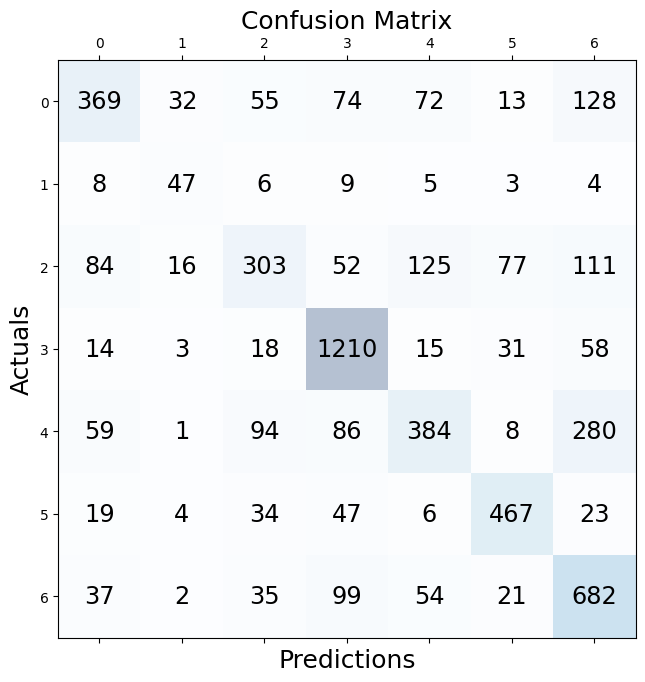

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_test2 ,axis=1), y_pred2)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

**Predictions**

---

1/1 [==============================] - 0s 38ms/step
predicted : Neutral


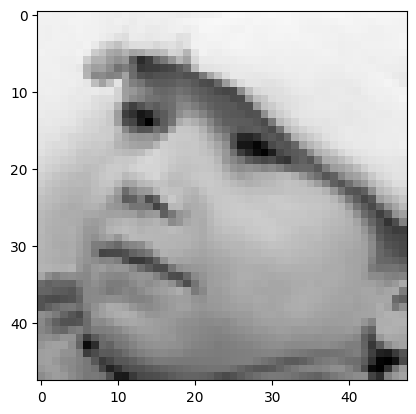

1/1 [==============================] - 0s 40ms/step
predicted : happy


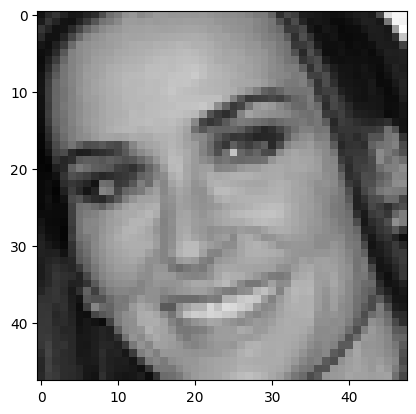

1/1 [==============================] - 0s 33ms/step
predicted : sad


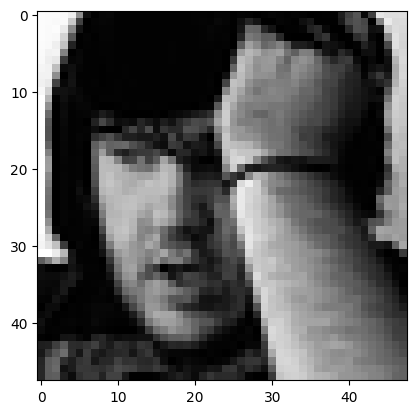

1/1 [==============================] - 0s 32ms/step
predicted : Surprise


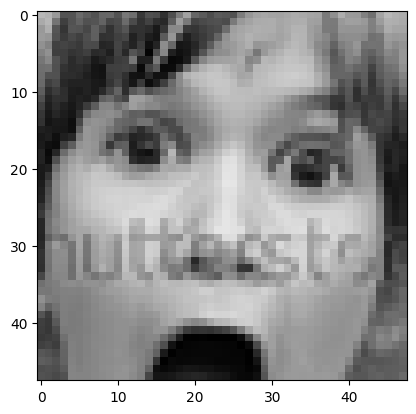

1/1 [==============================] - 0s 22ms/step
predicted : Angry


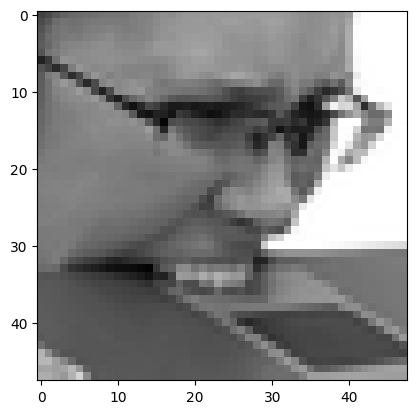

1/1 [==============================] - 0s 26ms/step
predicted : sad


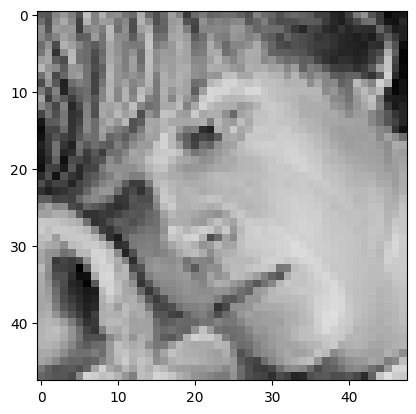

1/1 [==============================] - 0s 26ms/step
predicted : Angry


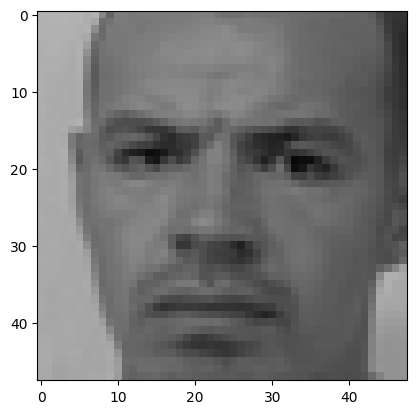

1/1 [==============================] - 0s 28ms/step
predicted : happy


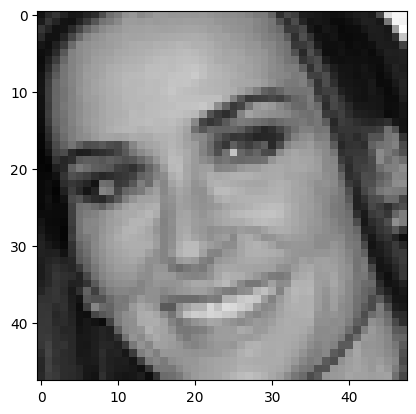

1/1 [==============================] - 0s 27ms/step
predicted : Neutral


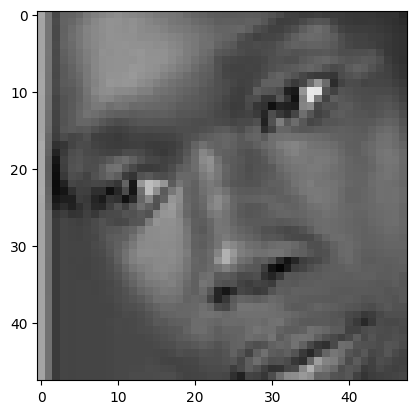

1/1 [==============================] - 0s 22ms/step
predicted : happy


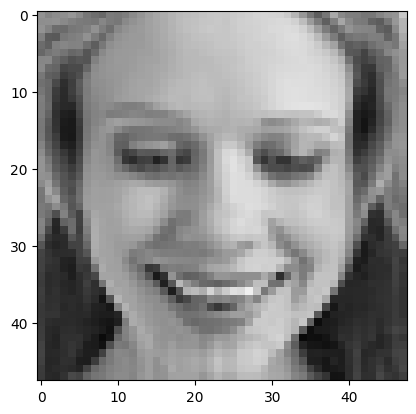

In [ ]:
for i in np.random.randint(0,high=100,size=10):
  prediction = model_tf.predict(tf.expand_dims(X_test2[i],0)).argmax()
  plt.imshow(X_test2[i])
  print("predicted :", Emotions[prediction])
  plt.show()